In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
%tensorflow_version 1.x
from __future__ import division
import tensorflow as tf
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import time
import os

**g**

In [42]:
CHAR_VOCAB_SIZE = 36 # Each char in the word can either be a digit 0-9 or a letter a-z giving a total of 36 pssible characters.
WORD_SIZE =5
IMAGE_WIDTH = 152
IMAGE_HEIGHT = 80
CAPTCHA_LENGTH = 5
NUM_CLASSES = 36
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 1000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 100
training_folder = "/content/drive/MyDrive/Data Images/imgs/"
testing_folder = "/content/drive/MyDrive/Data Images/test_imgs/"

In [48]:
def char_to_vec_pos(char):
    """
    Vector representation of length 36.
    First 10 positions are for digits 0-9
    Position 11-36 are for alphabets a-z
    :param char
    :return: returns the position of the char in the vector coding
    """
    ascii_val = ord(char)
    if ascii_val >= 48 and ascii_val<=57:
        return ascii_val-48
    if ascii_val >= 97 and ascii_val <=122:
        return (ascii_val-97)+10
    raise ValueError('Wrong character {}'.format(char))

In [49]:
def words_to_vec(word):
    """
    :param word: string of length 5 to be converted into vector
    :return: len*36 vector representation of word.
    """
    # print word
    word_len = len(word)
    vec = np.zeros(word_len * CHAR_VOCAB_SIZE)
    #print len(vec)

    for i,char in enumerate(word):
        idx = (i*CHAR_VOCAB_SIZE)+char_to_vec_pos(char)
        vec[idx]=1
    return vec

In [50]:
def load_dataset(folder, fromPos, toPos):
    file_list = os.listdir(folder)

    X = np.zeros([toPos - fromPos, IMAGE_HEIGHT * IMAGE_WIDTH])
    Y = np.zeros([toPos - fromPos, 5 * NUM_CLASSES])

    for i, filename in enumerate(file_list[fromPos:toPos]):
        path = folder + filename
        img = imread(path, as_gray=True)

        captcha_text = filename[0:CAPTCHA_LENGTH]

        X[i, :] = img.flatten()
        Y[i, :] = words_to_vec(captcha_text)

    X = normalize_data(X)
    return X, Y

In [71]:
def vec_to_word(vector):
    """
    :param vector: vector representation of word
    :return: string representation of the word
    """
    char_indices = vector.nonzero()[0]
    word = list()

    for idx in char_indices:
        vocab_idx = idx% CHAR_VOCAB_SIZE

        if vocab_idx < 10: # 0-9
            char_code = vocab_idx+ord('0')
        elif vocab_idx <= 35: # a-z
            char_code =  (vocab_idx - 10) + ord('a')
        else:
            raise ValueError("Incorrect character code")

        word.append(chr(char_code))

    return "".join(word)

In [72]:
def prediction_to_word(prediction_vector):
    """
    function to convert a prediction vector to captcha word
    :param prediction_vector: a [WORD_SIZE,CHAR_VOCAB_SIZE] np array of predictions
    :return: the string representing the word
    """
    b = np.zeros_like(prediction_vector)
    b[np.arange(len(prediction_vector)), prediction_vector.argmax(1)] = 1
    word_vector = np.reshape(b,WORD_SIZE*CHAR_VOCAB_SIZE)
    word = vec_to_word(word_vector)
    return word

In [73]:
def compare_predictions(predictions,labels):
    assert len(predictions == len(labels))
    print ("True   | Predicted")
    for i,prediction in enumerate(predictions):
        label = labels[i]
        predicted_word = prediction_to_word(prediction)
        true_word = vec_to_word(label)
        print ("{:7s}|{:10s}".format(true_word,predicted_word))

In [51]:
def normalize_data(X):
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    X = (X - x_mean) / (x_std + 0.00001)
    return X

In [52]:
def load_testing_dataset():
    no_files = len(os.listdir(testing_folder))
    return load_dataset(testing_folder, 0, no_files)

In [64]:
def training_dataset_length():
    return len(os.listdir(training_folder))

In [55]:
test_X, test_Y = load_testing_dataset()

In [56]:
X_input = tf.placeholder(tf.float32, [None, 152 * 80])
X = tf.reshape(X_input, shape=[-1, 152, 80, 1])
Y_ = tf.placeholder(tf.float32, [None, 5 * NUM_CLASSES])
learning_rate = 0.001

**MODEL DEFINITION**

In [57]:
def create_fully_connected_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))


def create_conv_weight(patch_height, patch_width, input_channel, output_channel):
    initial = tf.truncated_normal(shape=[patch_height, patch_width, input_channel, output_channel], stddev=0.1)
    return tf.Variable(initial)


def create_bias(shape):
    initial = 0.1 * tf.random_normal(shape=shape)
    return tf.Variable(initial)


def create_strides(batch_step, height_step, width_step, channel_step):
    return [batch_step, height_step, width_step, channel_step]


def create_conv_layer(input, W, strides, padding='SAME'):
    return tf.nn.conv2d(input, W, strides, padding)


def apply_max_pool(x, ksize, strides, padding='SAME'):
    return tf.nn.max_pool(x, ksize, strides, padding)

In [61]:
keep_prob = tf.placeholder(tf.float32)

W1 = create_conv_weight(5, 5, 1, 32)
B1 = create_bias([32])
strides1 = create_strides(1, 1, 1, 1)
Y1 = tf.nn.relu(create_conv_layer(X, W1, strides1, padding="SAME") + B1)
Y1 = apply_max_pool(Y1, [1, 2, 2, 1], [1, 2, 2, 1])
Y1 = tf.nn.dropout(Y1, keep_prob=keep_prob)

W2 = create_conv_weight(5, 5, 32, 64)
B2 = create_bias([64])
strides2 = create_strides(1, 1, 1, 1)
Y2 = tf.nn.relu(create_conv_layer(Y1, W2, strides2, padding="SAME") + B2)
Y2 = apply_max_pool(Y2, [1, 2, 2, 1], [1, 2, 2, 1])
Y2 = tf.nn.dropout(Y2, keep_prob=keep_prob)

W3 = create_conv_weight(5, 5, 64, 128)
B3 = create_bias([128])
strides3 = create_strides(1, 1, 1, 1)
Y3 = tf.nn.relu(create_conv_layer(Y2, W3, strides3, padding="SAME") + B3)
Y3 = apply_max_pool(Y3, [1, 2, 2, 1], [1, 2, 2, 1])
Y3 = tf.nn.dropout(Y3, keep_prob=keep_prob)

# keep_prob = tf.placeholder(tf.float32)

Y3 = tf.reshape(Y3, [-1, 19 * 10 * 128])

W4 = create_fully_connected_weight([19 * 10 * 128, 1024])
B4 = create_bias([1024])
Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
Y4 = tf.nn.dropout(Y4, keep_prob=keep_prob)

W5 = create_fully_connected_weight([1024, 5 * NUM_CLASSES])
B5 = create_bias([5 * NUM_CLASSES])
Ylogits = tf.matmul(Y4, W5) + B5

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = Ylogits,labels = Y_)
loss = tf.reduce_mean(cross_entropy)

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# prediction
predictions = tf.reshape(Ylogits, [-1, 5, NUM_CLASSES])
Ytrue = tf.reshape(Y_, [-1, 5, NUM_CLASSES])
correct_prediction = tf.equal(tf.argmax(predictions, 2), tf.argmax(Ytrue, 2))

# Define the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [66]:
# initialize
init = tf.initialize_all_variables()

saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)

n_classes = NUM_CLASSES
batch_size = 250
n_epochs = 15
n_batches_train = int(training_dataset_length() // batch_size)
print ("Number of Batches: %d" % (n_batches_train))

Number of Batches: 4


In [79]:
def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss = 0
    sum_all_batches_acc = 0
    sum_n_samples = 0

    for b in range(n_batches):

        offset = b * batch_size
        batch_data, batch_labels = load_dataset(training_folder, offset, offset + batch_size)
        # batch_data = data[offset: offset + batch_size, :]
        n_samples = batch_data.shape[0]

        # batch_labels = labels[offset: offset + batch_size]
        # batch_labels = (np.arange(n_classes) == batch_labels[:, None]).astype(np.float32)
        # print np.shape(batch_data)
        # print np.shape(batch_labels)

        feed_dict = {X_input: batch_data, Y_: batch_labels, keep_prob: 0.75}
        _, loss_value, a = sess.run([train_step, loss, accuracy], feed_dict=feed_dict)
        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if (n_samples != batch_size):
            print('n_samples =%d' % n_samples)

    print ("Sum of Samples trained %d" % (sum_n_samples))
    return (sum_all_batches_loss / sum_n_samples, sum_all_batches_acc / sum_n_samples)

In [68]:
def test_epochs(data=None, labels=None):
    # assert (data.shape[0] == labels.shape[0])
    # # labels = (np.arange(n_classes) == labels[:, None]).astype(np.float32)
    # feed_dict = {X_input: data, Y_: labels, keep_prob: 1}
    # test_a = sess.run([accuracy], feed_dict=feed_dict)
    return 1

In [84]:
def test_and_evaluate(data=None, labels=None):
    assert (data.shape[0] == labels.shape[0])
    feed_dict = {X_input: data, Y_: labels, keep_prob: 1}
    test_results = sess.run([predictions,correct_prediction,accuracy], feed_dict=feed_dict)
    test_preds = test_results[0]
    compare_predictions(test_results[0],labels)
    print ("Printing Correct Predictions")
    print ( test_results[1])
    #print test_results[1].shape
    return test_results

In [80]:
i = 1

train_ac = []
train_loss = []
test_ac = []
for e in range(n_epochs):
    start_time = time.time()
    n_data = training_dataset_length()
    # n_data = train_X.shape[0]
    # print n_data
    perm = np.random.permutation(n_data)
    # train_X = train_X[perm, :]
    # train_Y = train_Y[perm]
    mean_loss_per_sample_train, accuracy_per_sample_train = all_batches_run_train(n_batches_train)
    #test_a = test_epochs(data=test_X, labels=test_Y)
    print ("loss after epoch %d = %f: " % (i, mean_loss_per_sample_train))
    print ("train accuracy after epoch %d = %f: " % (i, accuracy_per_sample_train))
    #print "test accuracy after epoch %d = %f: " % (i, test_a[0])
    print ("-----------------------------------\n")
    i = i + 1
    train_ac.append(accuracy_per_sample_train)
    train_loss.append(mean_loss_per_sample_train)
#    test_ac.append(test_a[0])



print('Done Training')
save_path = saver.save(sess, "model.ckpt")

Sum of Samples trained 1000
loss after epoch 1 = 27.482387: 
train accuracy after epoch 1 = 0.027000: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 2 = 4.049715: 
train accuracy after epoch 2 = 0.039000: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 3 = 1.903239: 
train accuracy after epoch 3 = 0.049400: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 4 = 0.931968: 
train accuracy after epoch 4 = 0.046200: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 5 = 0.521235: 
train accuracy after epoch 5 = 0.048600: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 6 = 0.362641: 
train accuracy after epoch 6 = 0.048000: 
-----------------------------------

Sum of Samples trained 1000
loss after epoch 7 = 0.296186: 
train accuracy after epoch 7 = 0.044000: 
-----------------------------------

Sum of Samples trained 100

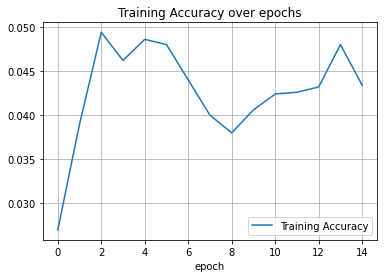

In [81]:
plt.title("Training Accuracy over epochs")
plt.plot(train_ac, label="Training Accuracy")
#plt.plot(test_ac, label="Test Accuracy")
plt.xlabel("epoch")
plt.legend(loc=4)
plt.grid(True)
plt.show()

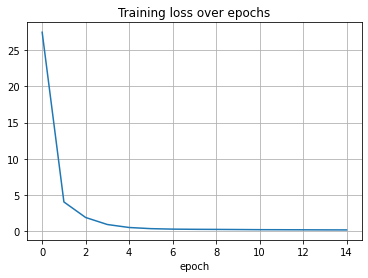

In [82]:
plt.title("Training loss over epochs")
plt.plot(train_loss, label="Training Loss")
plt.xlabel("epoch")
plt.grid(True)
plt.show()

In [ ]:
test_results = test_and_evaluate(data=test_X, labels=test_Y)
print('Done Testing')
print("Test Accuracy " + str(test_results[2]))